# 📥 Importing Libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# **🌐 Connect Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **📚 Extract Dataset**

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Kaggle/Flowers-Recognition.zip'
extract_to = '/content/Data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print(f'File diekstrak ke folder: {extract_to}')

File diekstrak ke folder: /content/Data


# 🗃️ Load Dataset

In [ ]:
path = '/content/Data/flowers'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()
print("Jumlah file per label:")
print(data['Labels'].value_counts())

import matplotlib.pyplot as plt

# Hitung jumlah gambar per label
label_counts = data['Labels'].value_counts()

# Buat ukuran dan warna
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color='cornflowerblue', edgecolor='black')

# Tambahkan label angka di atas setiap batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 10, f'{height}', ha='center', va='bottom', fontsize=10)

# Judul dan label
plt.title("Jumlah Gambar per Label", fontsize=16, weight='bold')
plt.xlabel("Label", fontsize=12)
plt.ylabel("Jumlah Gambar", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Simpan ke file PNG
plt.savefig("jumlah_gambar_per_label_bagus.png", dpi=300)
plt.close()


Jumlah file per label:
Labels
dandelion    1052
tulip         984
rose          784
daisy         764
sunflower     733
Name: count, dtype: int64


# 🔥 EDA & Visualization

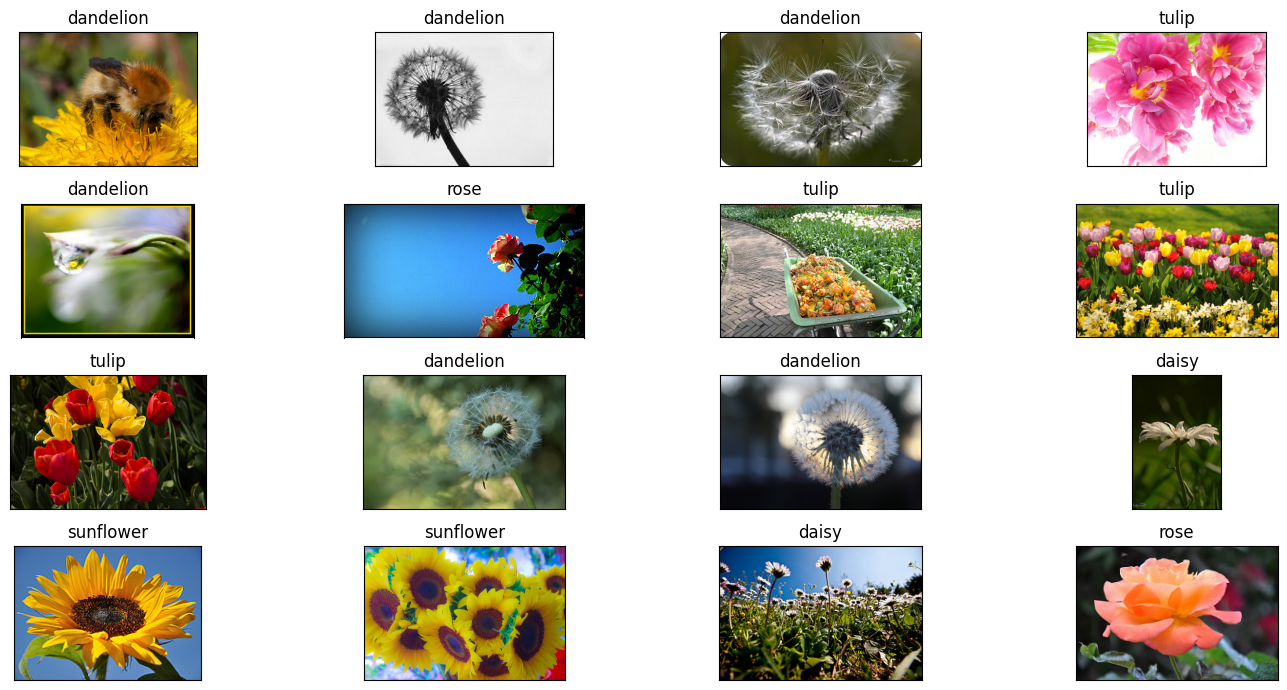

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

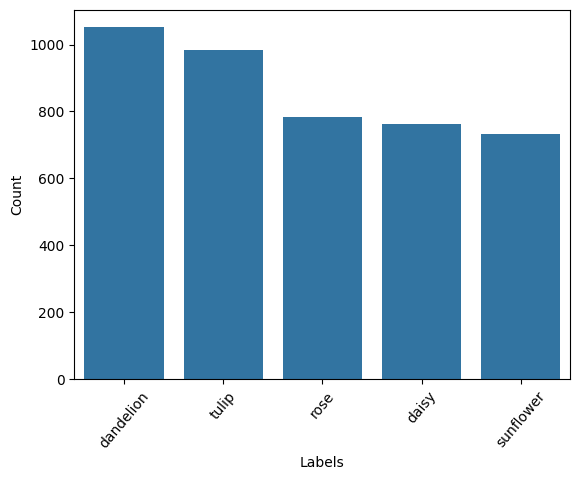

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

# ✂️ Train & Test Split

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.3, random_state=2)

 Membagi dataset data menjadi 80% untuk pelatihan model dan 20% untuk menguji kinerjanya,

# 🦾 Functions

In [ ]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.3)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

Fungsi `gen` digunakan untuk mempersiapkan data gambar dari DataFrame (train dan test) untuk pelatihan dan evaluasi model klasifikasi gambar
- `ImageDataGenerator`: digunakan untuk melakukan augmentasi data
- membuat generator data train, validation dan test (`train_gen`, `valid_gen`, `test_gen`)

In [ ]:
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

Fungsi untuk membuat dan mengompilasi sebuah model klasifikasi gambar menggunakan arsitektur transfer learning
- Input: Nama model Keras pra-latih (name_model).
- Memuat Model Pra-Latih: Membuat model dasar dengan bobot ImageNet, tanpa lapisan klasifikasi atas.
- Membekukan Lapisan: Mencegah bobot model pra-latih diubah selama pelatihan.
- Menambahkan Lapisan Baru: Menambahkan beberapa lapisan Dense untuk klasifikasi (dua lapisan 100 neuron ReLU, satu lapisan output 11 neuron Softmax).
- Membuat Model Akhir: Menggabungkan model pra-latih dan lapisan klasifikasi baru.
- Mengompilasi Model: Mengatur loss function, optimizer, dan metrik evaluasi.
- Membuat Early Stopping: Callback untuk menghentikan pelatihan jika validasi loss tidak membaik.
- Output: Model Keras yang sudah dikompilasi dan callback Early Stopping.

Intinya, fungsi ini membuat model klasifikasi gambar menggunakan transfer learning dengan model dasar yang sudah terlatih dan menambahkan lapisan klasifikasi spesifik, serta mengonfigurasi proses pelatihan

In [ ]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()

    return history

Fungsi plot ini bertujuan untuk memvisualisasikan kinerja model dan hasil prediksinya.

In [ ]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)

    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    return results

Fungsi result_test ini bertujuan untuk mengevaluasi kinerja model pada data uji dan menampilkan hasilnya

# 📚 Training models

Untuk menguji efektivitas implementasi klasifikasi CNN, kami melakukan eksperimen dengan berbagai model Convolutional Neural Network (CNN) yang populer, diantaranya EfficientNetB7, ResNet, MobileNet, VGG19, Xception, dan InceptionResNetV2.

## ✔️ DenseNet201

Found 2115 validated image filenames belonging to 5 classes.
Found 906 validated image filenames belonging to 5 classes.
Found 1296 validated image filenames belonging to 5 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Model selesai dilatih selama 4 epoch
41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 397ms/step
              precision    recall  f1-score   support

       daisy       0.83      0.86      0.84       242
   dandelion       0.84      0.88      0.86       319
        rose       0.80      0.81      0.81       231
   sunflower       0.83      0.88      0.85       204
       tulip       0.87      0.75      0.81       300

    accuracy                           0.83      1296
   macro avg       0.83      0.84      0.83      1296
weighted avg       0.84      0.83      0.83      1296



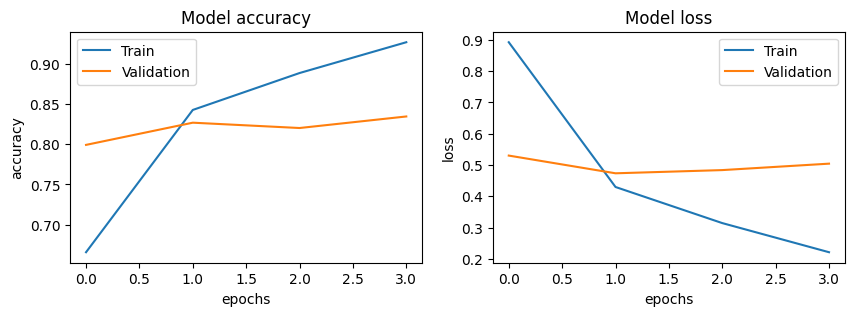

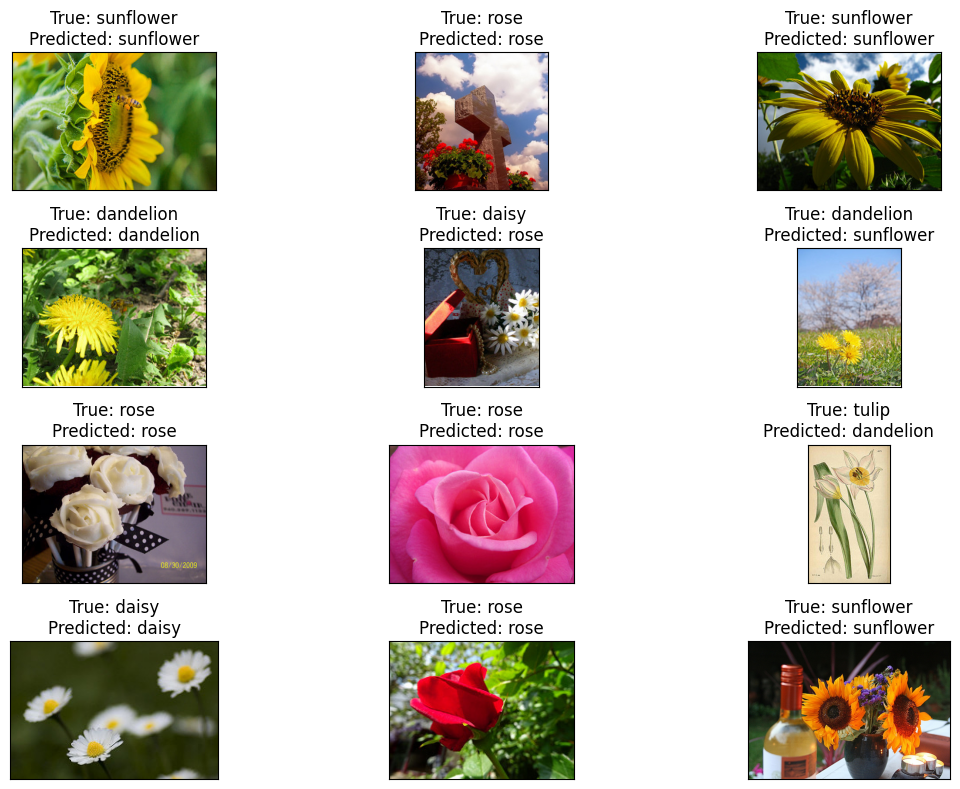

    Test Loss: 0.52503
Test Accuracy: 83.49%


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet121_pre=preprocess_input
train_gen_DenseNet121, valid_gen_DenseNet121, test_gen_DenseNet121 = gen(DenseNet121_pre,train_df,test_df)
model_DenseNet121, callback=func(DenseNet121)
history = model_DenseNet121.fit(
    train_gen_DenseNet121,
    validation_data=valid_gen_DenseNet121,
    epochs=100,
    callbacks=callback,
    verbose=0
)

# Cek jumlah epoch yang dilakukan
num_epochs = len(history.history['loss'])
print(f"✅ Model selesai dilatih selama {num_epochs} epoch")

history_DenseNet121=plot(history,test_gen_DenseNet121,train_gen_DenseNet121, model_DenseNet121)
result_DenseNet121 = result_test(test_gen_DenseNet121,model_DenseNet121)

In [ ]:
# Simpan model
model_DenseNet121.save("DenseNet121_trained_model.keras")
print("✅ Model disimpan ke DenseNet121_trained_model.keras")

history_DenseNet121 = pd.DataFrame(history.history)
history_DenseNet121.to_csv("DenseNet121_history.csv", index=False)
print("✅ History disimpan ke DenseNet121_history.csv")

# Simpan hasil prediksi
if isinstance(result_DenseNet121, pd.DataFrame):
    result_DenseNet121.to_csv("DenseNet121_result.csv", index=False)
    print("✅ Hasil prediksi disimpan ke DenseNet121_result.csv")
else:
    with open("DenseNet121_result.txt", "w") as f:
        for item in result_DenseNet121:
            f.write(f"{item}\n")
    print("✅ Hasil prediksi disimpan ke DenseNet121_result.txt")

✅ Model disimpan ke DenseNet121_trained_model.keras
✅ History disimpan ke DenseNet121_history.csv
✅ Hasil prediksi disimpan ke DenseNet121_result.txt


# 📝 Save Model, History, dan Result

In [ ]:
import json

# Semua result dan history training
model_results = {
    "EfficientNetB7": result_ENet,
    "ResNet50": result_ResNet,
    "MobileNet": result_MobileNet,
    "VGG19": result_VGG19,
    "Xception": result_Xception,
    "InceptionResNetV2": result_IRNV2,
    "VGG16": result_VGG16,
    "ResNet101": result_ResNet101,
    "DenseNet201": result_DenseNet201
}

model_histories = {
    "EfficientNetB7": history_ENet,
    "ResNet50": history_ResNet,
    "MobileNet": history_MobileNet,
    "VGG19": history_VGG19,
    "Xception": history_Xception,
    "InceptionResNetV2": history_IRNV2,
    "VGG16": history_VGG16,
    "ResNet101": history_ResNet101,
    "DenseNet201": history_DenseNet201
}

# Helper: ubah semua yang tidak bisa disimpan jadi json-friendly
def make_json_serializable(obj):
    if isinstance(obj, (list, dict, str, float, int, bool, type(None))):
        return obj
    try:
        return obj.tolist()
    except:
        return str(obj)

# Final format
full_data = {}

for model in model_results:
    full_data[model] = {
        "result": [make_json_serializable(x) for x in model_results[model]],
        "history": {k: make_json_serializable(v) for k, v in model_histories[model].items()}
    }

with open("results_history.json", "w") as f:
    json.dump(full_data, f, indent=4)

print("✅ Semua result dan history berhasil disimpan ke results_history.json")


✅ Semua result dan history berhasil disimpan ke results_history.json


In [ ]:
# Load Data History
with open("results_history.json", "r") as f:
    data = json.load(f)

# Buat DataFrame ringkasan akurasi
summary = pd.DataFrame({
    "Model": list(data.keys()),
    "Accuracy": [data[model]["result"][1] for model in data]
})

print(summary)


# 📊 Final Report

In [ ]:
output = pd.DataFrame({'Model':['DenseNet121'],
                      'Accuracy':[result_DenseNet121[1]]})

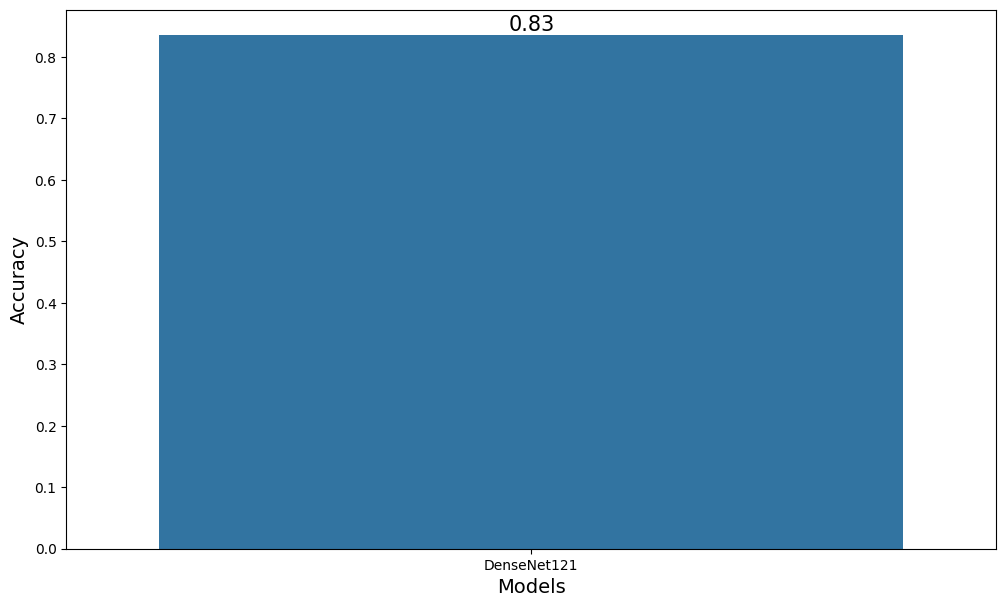

In [ ]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.ylabel("Accuracy", size=14)
plt.show()

# 🧪 TESTING

URL DEMO APP: https://recognizeflowers.streamlit.app/